# TFLego MNIST Examples

## Preliminary

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import sys
import tensorflow as tf

sys.path.append("..")
sys.path.append("../utils")

from tflego import blocks
from tflego import seq2seq
from tflego import training
from tflego.blocks import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import plotting

In [3]:
output_dir = "/tmp/data/"

In [10]:
?? tf.train.MomentumOptimizer


## Load MNIST data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(output_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


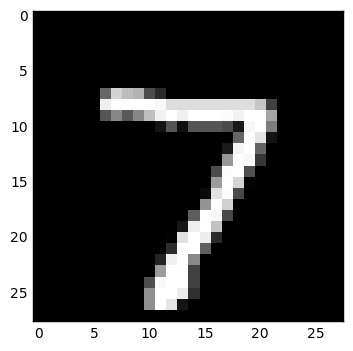

In [5]:
plt.imshow(np.reshape(mnist.test.images[0, :], (28, 28)), cmap="Greys_r", interpolation="nearest")

## Feedforward neural network

In [6]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 100
ff_keep_prob = 0.75

# Model parameters
n_input = 28*28
n_classes = 10
n_hiddens = [256, 256]

# Model
x = tf.placeholder(TF_DTYPE, [None, n_input])
y = tf.placeholder(TF_DTYPE, [None, n_classes])
keep_prob = tf.placeholder(TF_DTYPE)
ff = blocks.build_feedforward(x, n_hiddens, keep_prob)
with tf.variable_scope("ff_layer_final"):
    ff = blocks.build_linear(ff, n_classes)

# Training tensors
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(ff, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# optimizer = tf.train.AdadeltaOptimizer().minimize(loss)

# Test tensors
correct_prediction = tf.equal(tf.argmax(ff, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [7]:
# Train model

class MNISTTrainFeedIterator(object):
    def __iter__(self):
        n_batches = int(mnist.train.num_examples/batch_size)
        for i_batch in xrange(n_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            yield [batch_x, batch_y, ff_keep_prob]

class MNISTTestFeedIterator(object):
    def __iter__(self):
        yield [mnist.test.images, mnist.test.labels, 1.0]
            
# def mnist_test_feed_iterator():
#     yield [mnist.test.images, mnist.test.labels, 1.0]

model_fn = path.join(output_dir, "ff.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, MNISTTrainFeedIterator(),
    [x, y, keep_prob], accuracy, MNISTTestFeedIterator(),
    save_model_fn=model_fn
    )

2016-10-26 09:39:55.811728
Epoch 0: 2.847 sec, train loss: 0.421996, test loss: 0.9512
Epoch 1: 2.982 sec, train loss: 0.16737, test loss: 0.9665
Epoch 2: 3.123 sec, train loss: 0.122002, test loss: 0.9699
Epoch 3: 3.221 sec, train loss: 0.0981837, test loss: 0.9765
Epoch 4: 3.044 sec, train loss: 0.0828687, test loss: 0.9782
Writing: /tmp/data/ff.ckpt
Training time: 0.254 min
2016-10-26 09:40:11.368408


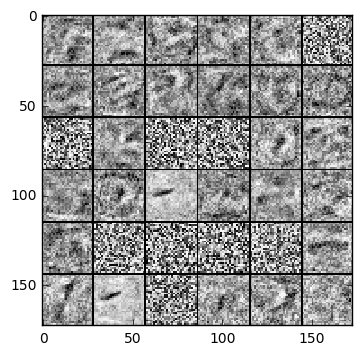

In [8]:
# Plot weights from first layer

# Weight tensor
with tf.variable_scope("ff_layer_0", reuse=True):
    W_0 = tf.get_variable("W", dtype=TF_DTYPE)

# Get weights
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    W_0 = W_0.eval()

image = Image.fromarray(plotting.tile_images(
    W_0.T, image_shape=(28, 28), tile_shape=(6, 6)
    ))
plt.imshow(image, cmap=plt.cm.Greys_r, interpolation="nearest")

## Convolutional neural network

In [12]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128
ff_keep_prob = 0.75

# Model parameters
n_input = 28*28
input_shape = [-1, 28, 28, 1]  # [n_data, height, width, d_in]
n_classes = 10
filter_shapes = [
    [5, 5, 1, 32],
    [5, 5, 32, 64]
    ]
pool_shapes = [
    [2, 2],
    [2, 2]
    ]
n_hiddens = [1024]

# Model
x = tf.placeholder(TF_DTYPE, [None, n_input])
y = tf.placeholder(TF_DTYPE, [None, n_classes])
keep_prob = tf.placeholder(TF_DTYPE)
cnn = blocks.build_cnn(x, input_shape, filter_shapes, pool_shapes, padding="SAME")
cnn = tf.contrib.layers.flatten(cnn)
cnn = blocks.build_feedforward(cnn, n_hiddens, keep_prob=keep_prob)
with tf.variable_scope("ff_layer_final"):
    cnn = blocks.build_linear(cnn, n_classes)

# Training tensors
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(cnn, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Test tensors
correct_prediction = tf.equal(tf.argmax(cnn, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [13]:
# Train model

class MNISTTrainFeedIterator(object):
    def __iter__(self):
        n_batches = int(mnist.train.num_examples/batch_size)
        for i_batch in xrange(n_batches):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            yield [batch_x, batch_y, ff_keep_prob]

class MNISTTestFeedIterator(object):
    def __iter__(self):
        yield [mnist.test.images, mnist.test.labels, 1.0]

model_fn = path.join(output_dir, "cnn.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, MNISTTrainFeedIterator(),
    [x, y, keep_prob], accuracy, MNISTTestFeedIterator(),
    save_model_fn=model_fn
    )

2016-10-31 09:30:04.248470
Epoch 0: 91.168 sec, train loss: 0.809736, test loss: 0.9602
Epoch 1: 93.048 sec, train loss: 0.108783, test loss: 0.9789
Epoch 2: 94.924 sec, train loss: 0.0757014, test loss: 0.9835
Epoch 3: 95.085 sec, train loss: 0.0581117, test loss: 0.9834
Epoch 4: 94.519 sec, train loss: 0.0508432, test loss: 0.9848
Writing: /tmp/data/cnn.ckpt
Training time: 7.812 min
2016-10-31 09:37:53.544272


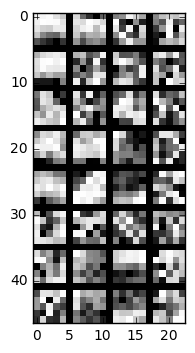

In [20]:
# Plot weights from first layer

# Weight tensor
with tf.variable_scope("cnn_layer_0", reuse=True):
    W_0 = tf.get_variable("W", dtype=TF_DTYPE)

# Get weights
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    W_0 = W_0.eval()

W_0 = np.transpose(W_0, (3, 2, 0, 1))

image = Image.fromarray(plotting.tile_images(
    W_0, image_shape=(5, 5), tile_shape=(8, 4)
    ))
plt.imshow(image, cmap=plt.cm.Greys_r, interpolation="nearest")

## Recurrent neural network

To train sequence models on MNIST, the columns of each image are considered a multivariate sequence.

In [568]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128

# Model parameters
n_input = 28
n_steps = 28  # timesteps
n_hidden = 128
n_classes = 10
rnn_type = "lstm"
rnn_keep_prob = 0.75

# Model
x = tf.placeholder(TF_DTYPE, [None, n_steps, n_input])
y = tf.placeholder(TF_DTYPE, [None, n_classes])
x_lengths = tf.fill([tf.shape(x)[0]], n_steps)
keep_prob = tf.placeholder(TF_DTYPE)
rnn_outputs, rnn_states = blocks.build_rnn(x, x_lengths, n_hidden, rnn_type=rnn_type, keep_prob=keep_prob)
if rnn_type == "lstm":
    rnn = rnn_states.h
elif rnn_type == "gru" or rnn_type == "rnn":
    rnn = rnn_states
else:
    assert False, "Invalid RNN type: {}".format(rnn_type)
with tf.variable_scope("ff_layer_final"):
    rnn = blocks.build_linear(rnn, n_classes)

# Training tensors
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(rnn, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Test tensors
correct_prediction = tf.equal(tf.argmax(rnn, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [569]:
# Train model

def mnist_train_feed_iterator():
    n_batches = int(mnist.train.num_examples/batch_size)
    for i_batch in xrange(n_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        yield [np.reshape(batch_x, (-1, 28, 28)), batch_y, rnn_keep_prob]

def mnist_test_feed_iterator():
    yield [np.reshape(mnist.test.images, (-1, 28, 28)), mnist.test.labels, 1.0]

model_fn = path.join(output_dir, "rnn.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, mnist_train_feed_iterator,
    [x, y, keep_prob], accuracy, mnist_test_feed_iterator,
    save_model_fn=model_fn
    )

2016-10-05 14:28:16.296648
Epoch 0: 27.260 sec, train loss: 0.57666, test loss: 0.93720
Epoch 1: 27.081 sec, train loss: 0.16835, test loss: 0.96030
Epoch 2:

KeyboardInterrupt: 

## Encoder-decoder version 1

This encoder-decoder is based on the *outback* implementation, where the output of the decoder is fed back as its own input.

In [198]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128

# Model parameters
n_input = 28
n_steps = 28  # timesteps
n_hidden = 128
rnn_type = "lstm"
# rnn_keep_prob = 1.0
output_activation = tf.nn.relu

# Model
x = tf.placeholder(TF_DTYPE, [None, n_steps, n_input])
x_lengths = tf.fill([tf.shape(x)[0]], n_steps)
network_tuple = seq2seq.build_encdec_outback(x, x_lengths, n_hidden, rnn_type=rnn_type, output_activation=output_activation)
encoder_states = network_tuple[0]
decoder_output = network_tuple[1]
# decoder_output = tf.sigmoid(decoder_output)
# decoder_output = tf.nn.relu(decoder_output)

# Training tensors
y_true = x
y_pred = decoder_output
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [199]:
# Train model

def mnist_train_feed_iterator():
    n_batches = int(mnist.train.num_examples/batch_size)
    for i_batch in xrange(n_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        yield [np.reshape(batch_x, (-1, 28, 28))]

def mnist_test_feed_iterator():
    yield [np.reshape(mnist.test.images, (-1, 28, 28))]

model_fn = path.join(output_dir, "encdec_outback.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, mnist_train_feed_iterator,
    [x], loss, mnist_test_feed_iterator,
    save_model_fn=model_fn
    )

2016-10-17 09:10:51.492239
Epoch 0: 57.692 sec, train loss: 0.07883, test loss: 0.05453
Epoch 1: 57.769 sec, train loss: 0.04737, test loss: 0.04276
Epoch 2: 58.089 sec, train loss: 0.04142, test loss: 0.04045
Epoch 3: 59.286 sec, train loss: 0.03898, test loss: 0.03802
Epoch 4: 60.681 sec, train loss: 0.03745, test loss: 0.03668
Writing: /tmp/data/encdec_outback.ckpt
Training time: 4.892 min
2016-10-17 09:15:47.903671


In [201]:
# Embeddings of the test data
n_test = 100
test_data = np.reshape(mnist.test.images, (-1, 28, 28))
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    test_encoder = session.run([encoder_states], feed_dict={x: test_data[:n_test, :]})
    test_decoder = session.run([decoder_output], feed_dict={x: test_data[:n_test, :]})
test_encoder = test_encoder[0]
test_decoder = test_decoder[0]
test_labels = mnist.test.labels[:n_test]
test_labels = np.argmax(test_labels, axis=1)  # convert from one-hot

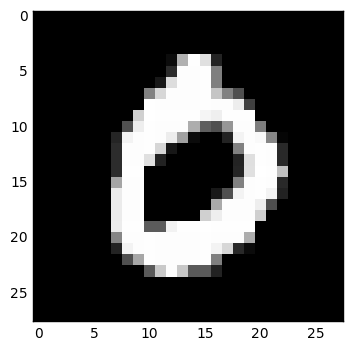

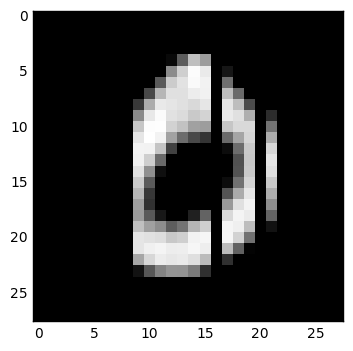

In [204]:
plt.imshow(test_data[3], cmap="Greys_r", interpolation="nearest")
plt.figure()
plt.imshow(test_decoder[3], cmap="Greys_r", interpolation="nearest")

(-0.5, 127.5, 99.5, -0.5)

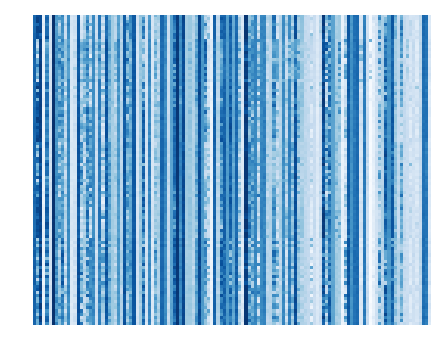

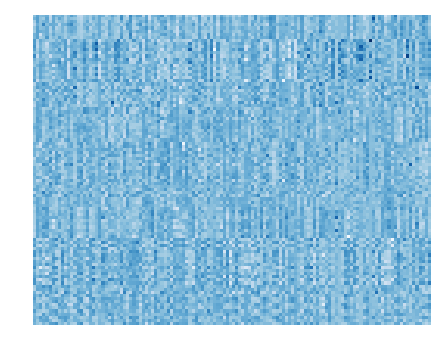

In [207]:
# Print sorted embeddings
indices_sorted = np.argsort(test_labels, axis=0)
test_encoder_sorted = test_encoder[indices_sorted, :]
plt.imshow(test_encoder_sorted, cmap="Blues_r", interpolation="nearest")
plt.axis('off')

# Apply mean and variance normalization
from sklearn import preprocessing
plt.figure()
plt.imshow(preprocessing.scale(test_encoder_sorted), cmap="Blues_r", interpolation="nearest")
plt.axis('off')

## Encoder-decoder version 2

This encoder-decoder is based on the *lazydynamic* implementation, where the encoder state is fed in as the input to the decoder at each time step.

In [233]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128

# Model parameters
n_input = 28
n_steps = 28  # timesteps
n_hidden = 128
rnn_type = "lstm"
# rnn_keep_prob = 1.0

# Model
x = tf.placeholder(TF_DTYPE, [None, n_steps, n_input])
x_lengths = tf.fill([tf.shape(x)[0]], n_steps)
network_tuple = seq2seq.build_encdec_lazydynamic(x, x_lengths, n_hidden, rnn_type=rnn_type)
encoder_states = network_tuple[0]
decoder_output = network_tuple[1]
# decoder_output = tf.sigmoid(decoder_output)
decoder_output = tf.nn.relu(decoder_output)

# Training tensors
y_true = x
y_pred = decoder_output
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [234]:
# Train model

def mnist_train_feed_iterator():
    n_batches = int(mnist.train.num_examples/batch_size)
    for i_batch in xrange(n_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        yield [np.reshape(batch_x, (-1, 28, 28))]

def mnist_test_feed_iterator():
    yield [np.reshape(mnist.test.images, (-1, 28, 28))]

model_fn = path.join(output_dir, "encdec_lazydynamic.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, mnist_train_feed_iterator,
    [x], loss, mnist_test_feed_iterator,
    save_model_fn=model_fn
    )

2016-10-17 09:41:33.857280
Epoch 0: 72.431 sec, train loss: 0.09099, test loss: 0.08161
Epoch 1: 74.178 sec, train loss: 0.07280, test loss: 0.06566
Epoch 2: 76.073 sec, train loss: 0.06251, test loss: 0.06142
Epoch 3: 78.954 sec, train loss: 0.06024, test loss: 0.05974
Epoch 4: 77.736 sec, train loss: 0.05875, test loss: 0.05877
Writing: /tmp/data/encdec_lazydynamic.ckpt
Training time: 6.323 min
2016-10-17 09:47:54.498902


In [235]:
# Embeddings of the test data
n_test = 100
test_data = np.reshape(mnist.test.images, (-1, 28, 28))
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    test_encoder = session.run([encoder_states], feed_dict={x: test_data[:n_test, :]})
    test_decoder = session.run([decoder_output], feed_dict={x: test_data[:n_test, :]})
test_encoder = test_encoder[0]
test_decoder = test_decoder[0]
test_labels = mnist.test.labels[:n_test]
test_labels = np.argmax(test_labels, axis=1)  # convert from one-hot

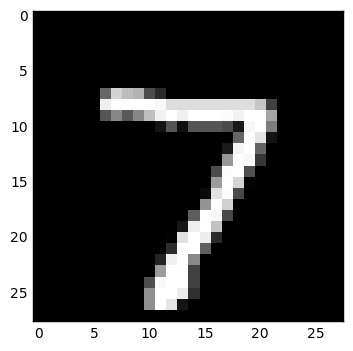

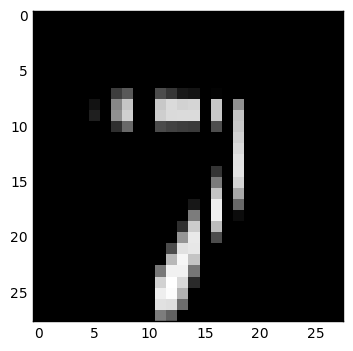

In [236]:
plt.imshow(test_data[0], cmap="Greys_r", interpolation="nearest")
plt.figure()
plt.imshow(test_decoder[0], cmap="Greys_r", interpolation="nearest")

(-0.5, 127.5, 99.5, -0.5)

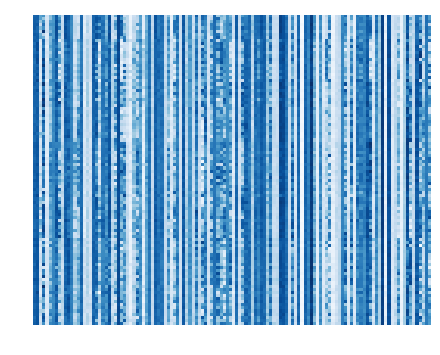

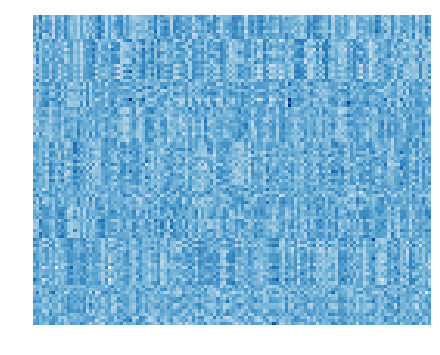

In [237]:
# Print sorted embeddings
indices_sorted = np.argsort(test_labels, axis=0)
test_encoder_sorted = test_encoder[indices_sorted, :]
plt.imshow(test_encoder_sorted, cmap="Blues_r", interpolation="nearest")
plt.axis('off')

# Apply mean and variance normalization
plt.figure()
plt.imshow(preprocessing.scale(test_encoder_sorted), cmap="Blues_r", interpolation="nearest")
plt.axis('off')